# Evaluation

In [1]:
import os
import logging
import subprocess
from pathlib import Path

## Setup

### Store Directory

In [2]:
storedir = None  # Set this to persist evaluation results/checkpoints

In [3]:
if storedir is not None:
    checkpoint_storedir = f"{storedir}/checkpoints"
    Path(checkpoint_storedir).mkdir(exist_ok=True)

    data_storedir = f"{storedir}/data"
    Path(data_storedir).mkdir(exist_ok=True)
else:
    checkpoint_storedir = None
    data_storedir = None
    
try:
    job_id = os.environ['PBS_JOBID'].split('.pbs')[0]
except KeyError:
    job_id = 'local'

In [4]:
logging.basicConfig()
logger = logging.getLogger('job')
logger.setLevel(logging.INFO)

### Imports

In [5]:
logger.info('Importing third-party packages ...')

import torch
from torch.utils.data import DataLoader, Subset, ConcatDataset, random_split
from tqdm import tqdm

from volatility_smoothing.utils.chunk import chunked
from volatility_smoothing.utils.train.loss import Loss
from volatility_smoothing.utils.options_data import SPXOptionsDataset, WRDSOptionsDataset
from volatility_smoothing.utils.train.dataset import GNOOptionsDataset
from volatility_smoothing.utils.chunk import chunked
from volatility_smoothing.utils.train import misc

INFO:job:Importing third-party packages ...


### Device

In [6]:
logger.info(f"Defining device (torch.cuda.is_available()={torch.cuda.is_available()})")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

logger.info(f'Running using device `{device}`')

if device.type == 'cuda':
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    formatted_result = str(result.stdout).replace('\\n', '\n').replace('\\t', '\t')##

    logger.info(formatted_result)
    logger.info(f'Device count: {torch.cuda.device_count()}')
    logger.info(f'Visible devices count: {os.environ["CUDA_VISIBLE_DEVICES"]}')

INFO:job:Defining device (torch.cuda.is_available()=False)
INFO:job:Running using device `cpu`


## Datasets

In [7]:
os.environ['OPDS_CACHE_DIR'] = os.path.expanduser('~/.cache/opds')  # directory where to place the processed files
os.environ['OPDS_WRDS_DATA_DIR'] = os.path.abspath("../data/openbb/spx")  # <- .csv file from WRDS should be place inside this directory
dataset = WRDSOptionsDataset()

In [8]:
from datetime import datetime
from volatility_smoothing.utils.options_data import OptionsDataset


def split_dataset(dataset: OptionsDataset):
    """
    Modified for single-day OpenBB data demo.
    
    Original function splits dataset into <2021 training and 2021 test portions.
    This version uses all available data for evaluation only (no training/finetuning).
    """
    # Get all indices
    all_indices = list(range(len(dataset)))
    
    logger.info(f"Dataset contains {len(dataset)} surface(s)")
    logger.info(f"Using all data for evaluation (single-day demo mode)")
    
    # Empty training and dev sets (no finetuning)
    train_dataset = Subset(GNOOptionsDataset(dataset), [])
    dev_dataset = Subset(GNOOptionsDataset(dataset), [])
    
    # Put all data in first test set
    test_datasets = [Subset(GNOOptionsDataset(dataset), all_indices)]
    
    # Add 11 empty test datasets to maintain compatibility with original code structure
    test_datasets.extend([Subset(GNOOptionsDataset(dataset), []) for _ in range(11)])
    
    logger.info(f"Train dataset size: {len(train_dataset)} (empty - demo mode)")
    logger.info(f"Dev dataset size: {len(dev_dataset)} (empty - demo mode)")
    logger.info(f"Test dataset size: {len(test_datasets[0])} (all available data)")
    
    return train_dataset, dev_dataset, test_datasets

In [9]:
train_dataset, dev_dataset, test_datasets = split_dataset(dataset)

INFO:job:Dataset contains 1 surface(s)
INFO:job:Using all data for evaluation (single-day demo mode)
INFO:job:Train dataset size: 0 (empty - demo mode)
INFO:job:Dev dataset size: 0 (empty - demo mode)
INFO:job:Test dataset size: 1 (all available data)


## Model and Optimizer

In [10]:
lr = 1e-4
weight_decay = 1e-5

checkpoint_path = "../train/store/9448705/checkpoints/checkpoint_final.pt"
model, _ = misc.load_checkpoint(checkpoint_path, device=device)
model.to(device);
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay) 

## Evaluation/Finetuning Hyperparameters

In [11]:
num_workers = 4

epochs = 0  # Finetune epochs, set to 0 to skip and just evaluate
batch_size = 32  # Finetune batch size, will be augmented by same amount of training data

# mesh sizes on which to evaluate arbitrage metrics
step_r = 0.01
step_z = 0.01

In [12]:
train_loss = Loss()
dev_loss = Loss(step_r=step_r, step_z=step_z)

## Evaluation

In [13]:
def finetune(model, optimizer, train_dataset: GNOOptionsDataset, finetune_dataset: GNOOptionsDataset, dev_dataset: GNOOptionsDataset, **kwargs):

    logger = logging.getLogger('job')

    kwargs = kwargs.copy()
    num_workers = kwargs.pop('num_workers', 0)
    epochs = kwargs.pop('epochs', 10)
    batch_size = kwargs.pop('batch_size', 64)
    dev_loss = kwargs.pop('dev_loss', Loss())
    callback = kwargs.pop('callback', lambda sample_loss: sample_loss.backward())
    checkpoint_storedir = kwargs.pop('checkpoint_storedir', None)

    loss = Loss(**kwargs)
    train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=loss.collate_fn, shuffle=True, num_workers=num_workers, pin_memory=False)
    finetune_dataloader = DataLoader(finetune_dataset, batch_size=1, collate_fn=train_loss.collate_fn, shuffle=True, num_workers=num_workers, pin_memory=False)

    logger.info(50 * "=")
    logger.info("Training start:")
    logger.info(f"Epochs: {epochs}")
    logger.info(loss)
    logger.info(50 * "=")

    for epoch in range(epochs):
        model.train()

        train_iterator = iter(train_dataloader)
        finetune_iterator = iter(finetune_dataloader)

        for batch_idx in (iterations := tqdm(chunked(list(range(len(finetune_dataloader))), batch_size))):
            batch = ([next(train_iterator) for _ in batch_idx]
                     + [next(finetune_iterator) for _ in batch_idx])
            
            optimizer.zero_grad()
            batch_loss, loss_infos = loss.compute_batch_loss(model, batch, callback, device)
            loss_str = loss.format_loss_str(loss_infos)                                        
            iterations.set_description(loss_str)
            optimizer.step()
        
            if (iterations.n % 10 == 0) and (storedir is not None):
                logger.info(f"Epoch {epoch}; {iterations.n}/{len(iterations)} -- {loss_str}")

        # Dev loss
        df_val, df_rel, df_fit = dev_loss.evaluate(model, dev_dataset, device=device, num_workers=num_workers)
        logger.info(f"Epoch {epoch} Dev: {df_val.describe()}")

        # Checkpointing
        if checkpoint_storedir is not None and not batch_loss.isnan():
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            torch.save(checkpoint, f"{checkpoint_storedir}/{job_id}_checkpoint_{epoch}.pt")

    return model

In [14]:
torch.cuda.empty_cache()

logger.info(50 * "=")
logger.info(f"Evaluation start (Retraining epochs: {epochs}).")
logger.info(50 * "=")

finetune_dataset = Subset(train_dataset, [])
try:
    for k, test_dataset in enumerate(test_datasets):
        # Skip empty test datasets
        if len(test_dataset) == 0:
            logger.info(f"Skipping empty test dataset {k}")
            continue
        
        logger.info(f"Evaluating test dataset {k} (size: {len(test_dataset)})")
        df_val, df_rel, df_fit = dev_loss.evaluate(model, test_dataset, device=device, num_workers=num_workers, storedir=storedir, logger=logger)

        finetune_dataset = ConcatDataset([finetune_dataset, test_dataset])
        
        # Skip finetuning if epochs=0 or train_dataset is empty
        if epochs > 0 and len(train_dataset) > 0:
            logger.info(f"Finetuning on test dataset {k}")
            finetune(model, optimizer, train_dataset, finetune_dataset, dev_dataset,
                     dev_loss=dev_loss, epochs=epochs, batch_size=batch_size, num_workers=num_workers, checkpoint_storedir=checkpoint_storedir)
        else:
            logger.info(f"Skipping finetuning (epochs={epochs}, train_size={len(train_dataset)})")

except KeyboardInterrupt:
    logging.info("Training aborted")
else:
    logging.info("Training complete")
finally:
    if checkpoint_storedir is not None:
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(model, f"{checkpoint_storedir}/checkpoint_final.pt")
    model.eval()

INFO:job:==================================================
INFO:job:Evaluation start (Retraining epochs: 0).
INFO:job:==================================================
INFO:job:Evaluating test dataset 0 (size: 1)
INFO:job:Evaluated quote datetime 2025-12-07 00:00:00
INFO:job:Skipping finetuning (epochs=0, train_size=0)
INFO:job:Skipping empty test dataset 1
INFO:job:Skipping empty test dataset 2
INFO:job:Skipping empty test dataset 3
INFO:job:Skipping empty test dataset 4
INFO:job:Skipping empty test dataset 5
INFO:job:Skipping empty test dataset 6
INFO:job:Skipping empty test dataset 7
INFO:job:Skipping empty test dataset 8
INFO:job:Skipping empty test dataset 9
INFO:job:Skipping empty test dataset 10
INFO:job:Skipping empty test dataset 11


In [18]:
dataset.quote_datetimes[surface_idx]

Timestamp('2025-12-07 00:00:00')


Surface date: 2025-12-07 00:00:00

Array sizes:
  rho: (9022,)
  z: (9022,)
  iv_market: (9022,)
  iv_smoothed: (9022,)
  tau: (9022,)

Data ranges:
  ρ (√τ): [0.0523, 0.9764]
  z: [-1.4987, 0.4987]
  IV market: [0.0874, 0.6084]
  IV smoothed: [0.0933, 0.5740]

Smoothing statistics:
  Market IV std: 0.102371
  Smoothed IV std: 0.096244
  Std reduction: 5.99%
  Mean |difference|: 0.006449
  Max |difference|: 0.050598
CREATING 3D SCATTER PLOTS


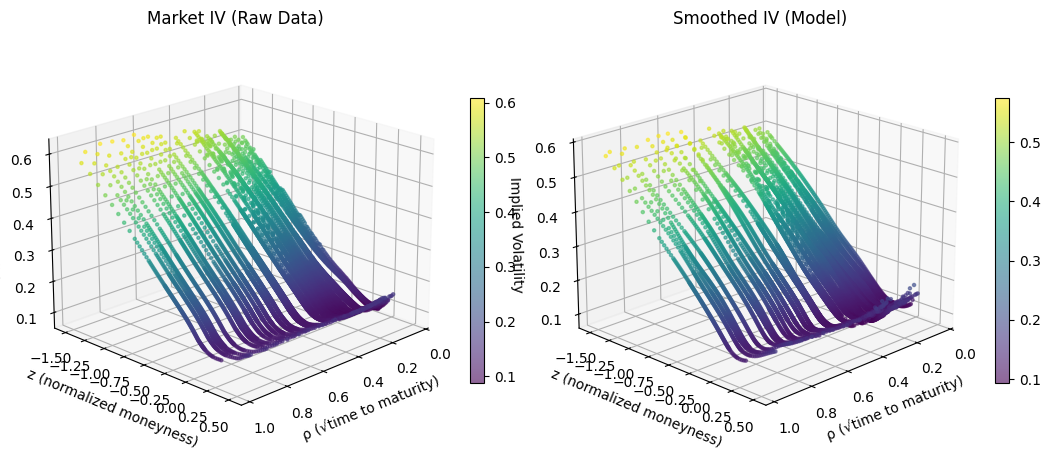

CREATING VOLATILITY SMILES
Number of unique maturities: 46


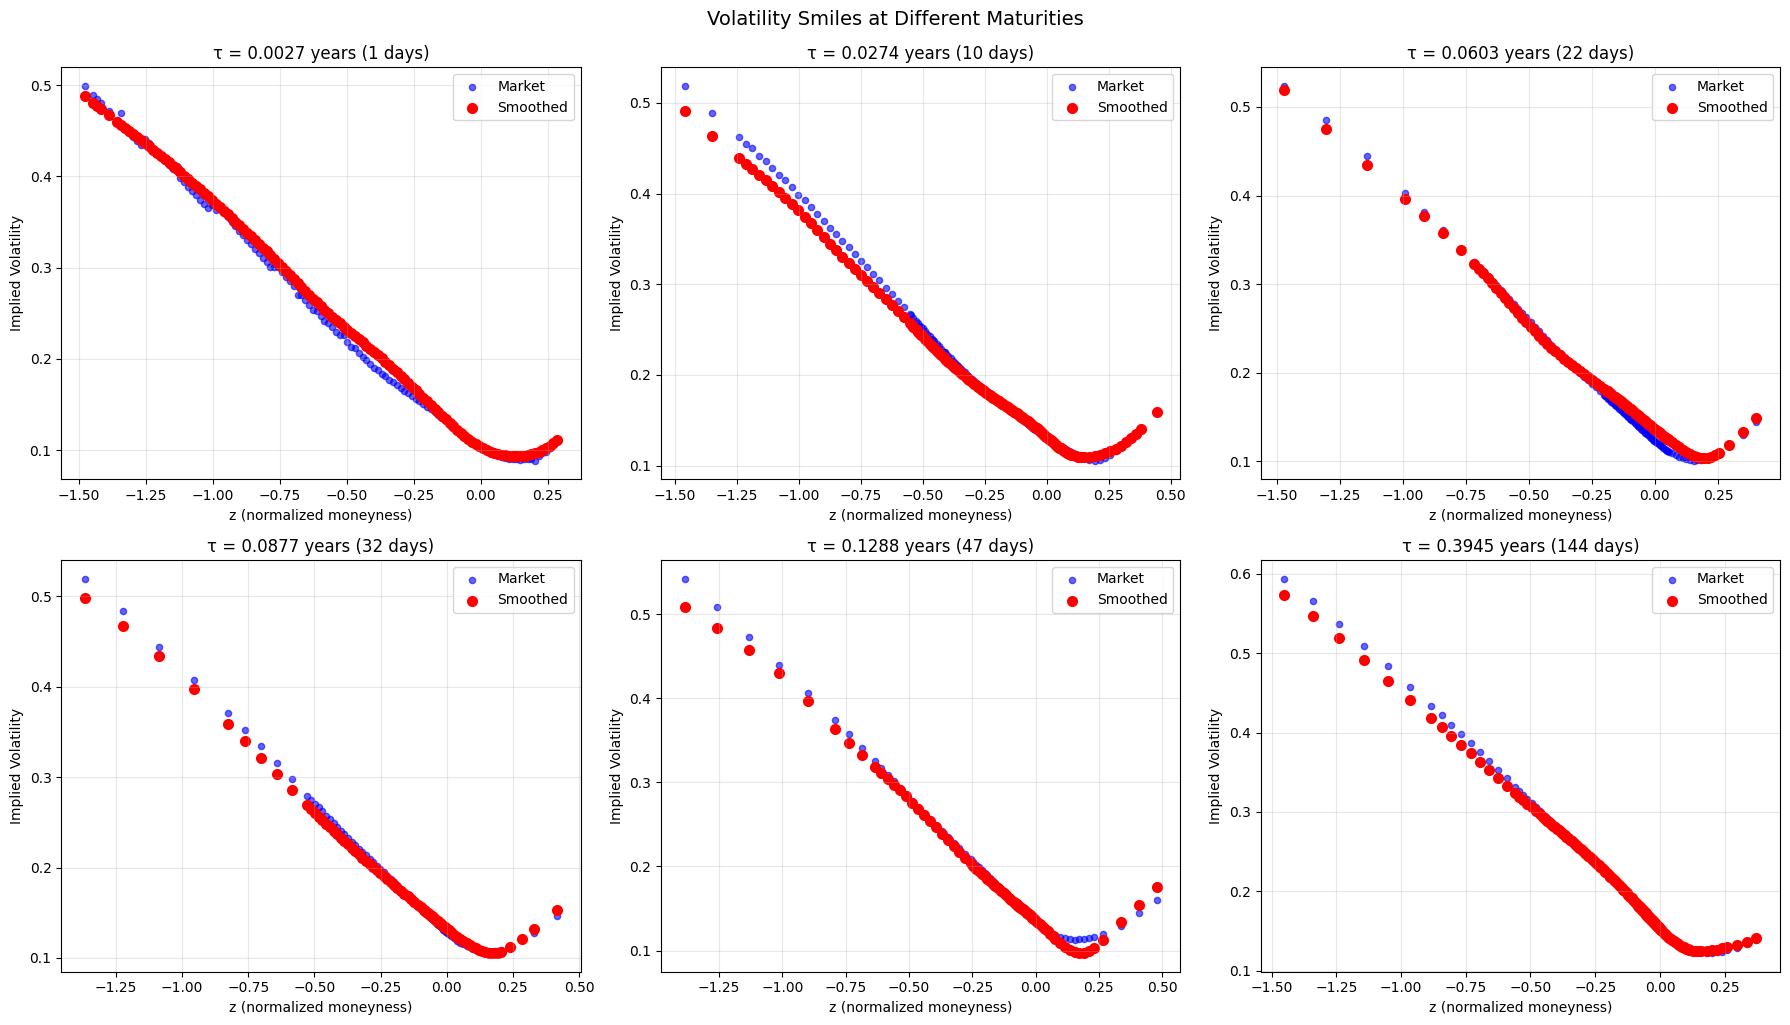

In [22]:
# ============================================================================
# VISUALIZATION: Smoothed Volatility Surface from OpenBB SPX Data
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

surface_idx = 0
print(f"\nSurface date: {dataset.quote_datetimes[surface_idx]}")

# Get model predictions and filtered data
model.eval()
with torch.no_grad():
    gno_dataset = GNOOptionsDataset(dataset)
    batch = gno_dataset[surface_idx]
    
    from torch.utils.data import DataLoader
    dataloader = DataLoader([batch], batch_size=1, collate_fn=dev_loss.collate_fn)
    
    for data, input, aux in dataloader:
        input = {k: v.to(device) if torch.is_tensor(v) else v for k, v in input.items()}
        output = model(**input)

        #iv_smoothed_tensor -> Predictions at the SAME scattered input locations where market data exists
        #iv_surface -> Predictions on a NEW regular grid created for evaluation
        
        iv_smoothed_tensor, iv_surface, *_ = dev_loss.read_output(output, aux)
        
        # Extract and flatten all arrays
        rho = data['r'].cpu().numpy().ravel()
        z = data['z'].cpu().numpy().ravel()
        iv_market = data['implied_volatility'].cpu().numpy().ravel()
        iv_smoothed = iv_smoothed_tensor.cpu().numpy().ravel()
        tau = data['time_to_maturity'].cpu().numpy().ravel()
        
        break

# Verify all arrays have same size
print(f"\nArray sizes:")
print(f"  rho: {rho.shape}")
print(f"  z: {z.shape}")
print(f"  iv_market: {iv_market.shape}")
print(f"  iv_smoothed: {iv_smoothed.shape}")
print(f"  tau: {tau.shape}")

assert rho.shape == z.shape == iv_market.shape == iv_smoothed.shape == tau.shape, "Array size mismatch!"

print(f"\nData ranges:")
print(f"  ρ (√τ): [{rho.min():.4f}, {rho.max():.4f}]")
print(f"  z: [{z.min():.4f}, {z.max():.4f}]")
print(f"  IV market: [{iv_market.min():.4f}, {iv_market.max():.4f}]")
print(f"  IV smoothed: [{iv_smoothed.min():.4f}, {iv_smoothed.max():.4f}]")

diff = iv_market - iv_smoothed
print(f"\nSmoothing statistics:")
print(f"  Market IV std: {iv_market.std():.6f}")
print(f"  Smoothed IV std: {iv_smoothed.std():.6f}")
print(f"  Std reduction: {(1 - iv_smoothed.std()/iv_market.std())*100:.2f}%")
print(f"  Mean |difference|: {np.abs(diff).mean():.6f}")
print(f"  Max |difference|: {np.abs(diff).max():.6f}")

# ============================================================================
# 3D SCATTER PLOTS
# ============================================================================

print("CREATING 3D SCATTER PLOTS")

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(rho, z, iv_market, c=iv_market, cmap='viridis', s=5, alpha=0.6)
ax1.set_xlabel('ρ (√time to maturity)')
ax1.set_ylabel('z (normalized moneyness)')
ax1.set_zlabel('Implied Volatility')
ax1.set_title('Market IV (Raw Data)')
ax1.view_init(elev=20, azim=45)
plt.colorbar(scatter1, ax=ax1, shrink=0.5)

ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(rho, z, iv_smoothed, c=iv_smoothed, cmap='viridis', s=5, alpha=0.6)
ax2.set_xlabel('ρ (√time to maturity)')
ax2.set_ylabel('z (normalized moneyness)')
ax2.set_zlabel('Implied Volatility')
ax2.set_title('Smoothed IV (Model)')
ax2.view_init(elev=20, azim=45)
plt.colorbar(scatter2, ax=ax2, shrink=0.5)

# ax3 = fig.add_subplot(133, projection='3d')
# scatter3 = ax3.scatter(rho, z, diff, c=diff, cmap='RdBu', s=5, alpha=0.6)
# ax3.set_xlabel('ρ (√time to maturity)')
# ax3.set_ylabel('z (normalized moneyness)')
# ax3.set_zlabel('IV Difference')
# ax3.set_title('Market - Smoothed')
# ax3.view_init(elev=20, azim=45)
# plt.colorbar(scatter3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()


# ============================================================================
# VOLATILITY SMILES
# ============================================================================

print("CREATING VOLATILITY SMILES")

tau_unique = np.unique(np.round(tau, 4))
print(f"Number of unique maturities: {len(tau_unique)}")

n_plots = min(6, len(tau_unique))
tau_selected = tau_unique[::max(1, len(tau_unique)//n_plots)][:n_plots]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, tau_val in enumerate(tau_selected):
    mask = np.abs(tau - tau_val) < 1e-4
    if not mask.any():
        continue
    
    z_slice = z[mask]
    iv_market_slice = iv_market[mask]
    iv_smoothed_slice = iv_smoothed[mask]
    
    sort_idx = np.argsort(z_slice)
    z_slice = z_slice[sort_idx]
    iv_market_slice = iv_market_slice[sort_idx]
    iv_smoothed_slice = iv_smoothed_slice[sort_idx]
    
    axes[i].scatter(z_slice, iv_market_slice, s=20, alpha=0.6, label='Market', color='blue')
    axes[i].scatter(z_slice, iv_smoothed_slice, linewidth=2, label='Smoothed', color='red')
    axes[i].set_xlabel('z (normalized moneyness)')
    axes[i].set_ylabel('Implied Volatility')
    axes[i].set_title(f'τ = {tau_val:.4f} years ({tau_val*365:.0f} days)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Volatility Smiles at Different Maturities', y=1.02, fontsize=14)
plt.show()


## Volatility Smiles on Grid

Number of unique maturities in market data: 46


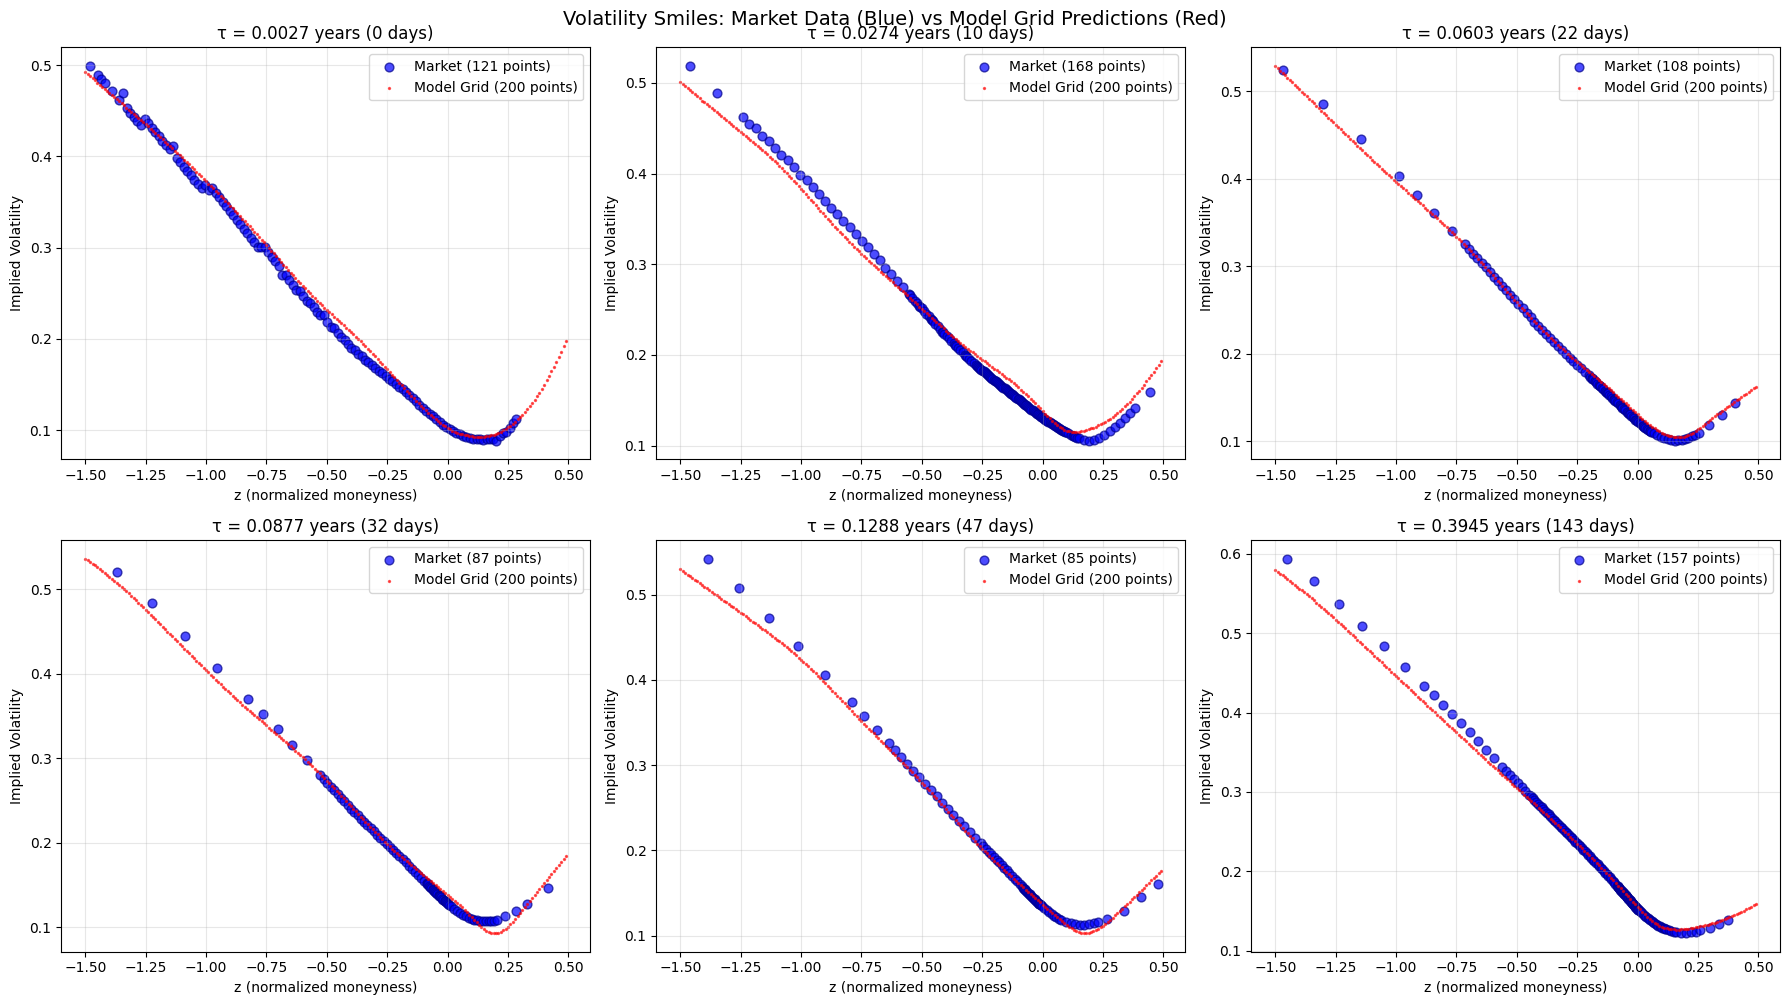

In [23]:
# Get model surface on grid
grid = aux['grids'][0]
rho_grid = grid['r'].cpu().numpy()
z_grid = grid['z'].cpu().numpy()
iv_surface_np = iv_surface.cpu().numpy()

# Select maturities from ACTUAL MARKET DATA (same as Cell-23)
tau_unique = np.unique(np.round(tau, 4))
print(f"Number of unique maturities in market data: {len(tau_unique)}")

n_plots = min(6, len(tau_unique))
tau_selected = tau_unique[::max(1, len(tau_unique)//n_plots)][:n_plots]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, tau_val in enumerate(tau_selected):
    # Get ACTUAL market data for this maturity (tight tolerance like Cell-23)
    mask = np.abs(tau - tau_val) < 1e-4
    if not mask.any():
        axes[i].axis('off')
        continue
    
    z_market = z[mask]
    iv_market_slice = data['implied_volatility'].cpu().numpy()[mask]
    
    # Sort market data
    sort_idx = np.argsort(z_market)
    z_market = z_market[sort_idx]
    iv_market_slice = iv_market_slice[sort_idx]
    
    # Find closest rho in model grid
    rho_val = np.sqrt(tau_val)
    rho_idx = np.argmin(np.abs(rho_grid[:, 0] - rho_val))
    
    # Extract model predictions from grid - 200 evenly-spaced points
    z_smooth = z_grid[rho_idx, :]      # [200] evenly-spaced
    iv_smooth = iv_surface_np[rho_idx, :]  # [200] on grid
    
    # Plot BOTH as scatter points to show difference in number of points
    axes[i].scatter(z_market, iv_market_slice, s=40, alpha=0.7,
                    label=f'Market ({len(z_market)} points)', color='blue', marker='o', edgecolors='darkblue')
    axes[i].scatter(z_smooth, iv_smooth, s=8, alpha=0.6,
                    label=f'Model Grid (200 points)', color='red', marker='.')
    axes[i].set_xlabel('z (normalized moneyness)')
    axes[i].set_ylabel('Implied Volatility')
    axes[i].set_title(f'τ = {tau_val:.4f} years ({int(tau_val*365)} days)')
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

# Turn off empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Volatility Smiles: Market Data (Blue) vs Model Grid Predictions (Red)', y=1.00, fontsize=14)
plt.show()


In [24]:
# Display evaluation metrics computed during the evaluation
import pandas as pd

print("="*80)
print("EVALUATION METRICS SUMMARY")
print("="*80)

# Check if df_val exists from the evaluation
if 'df_val' in locals() or 'df_val' in globals():
    print("\n1. VALIDATION LOSSES:")
    print("-" * 80)
    print(df_val)
    print("\n")
    
if 'df_rel' in locals() or 'df_rel' in globals():
    print("2. RELATIVE ERRORS (Market vs Model):")
    print("-" * 80)
    print(df_rel)
    print("\n")
    
if 'df_fit' in locals() or 'df_fit' in globals():
    print("3. SPREAD ERRORS (Bid-Ask Fitting):")
    print("-" * 80)
    print(df_fit)
    print("\n")

# If the dataframes don't exist yet, compute basic error metrics
if not ('df_val' in locals() or 'df_val' in globals()):
    print("\nComputing error metrics from model predictions...")
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        gno_dataset = GNOOptionsDataset(dataset)
        batch = gno_dataset[0]
        
        from torch.utils.data import DataLoader
        dataloader = DataLoader([batch], batch_size=1, collate_fn=dev_loss.collate_fn)
        
        for data, input, aux in dataloader:
            input = {k: v.to(device) if torch.is_tensor(v) else v for k, v in input.items()}
            output = model(**input)
            
            iv_pred_tensor, _, *_ = dev_loss.read_output(output, aux)
            
            iv_market = data['implied_volatility'].cpu().numpy().ravel()
            iv_pred = iv_pred_tensor.cpu().numpy().ravel()
            bid = data['bid'].cpu().numpy().ravel()
            ask = data['ask'].cpu().numpy().ravel()
            
            break
    
    # Compute error metrics
    absolute_error = np.abs(iv_pred - iv_market)
    relative_error = absolute_error / iv_market * 100  # percentage
    spread = ask - bid
    spread_error = absolute_error / spread  # error relative to bid-ask spread
    
    print("\n" + "="*80)
    print("ERROR STATISTICS")
    print("="*80)
    
    print("\nAbsolute Error (|Predicted - Market|):")
    print(f"  Mean:   {absolute_error.mean():.6f}")
    print(f"  Median: {np.median(absolute_error):.6f}")
    print(f"  Std:    {absolute_error.std():.6f}")
    print(f"  Min:    {absolute_error.min():.6f}")
    print(f"  Max:    {absolute_error.max():.6f}")
    print(f"  95th percentile: {np.percentile(absolute_error, 95):.6f}")
    
    print("\nRelative Error (%):")
    print(f"  Mean:   {relative_error.mean():.2f}%")
    print(f"  Median: {np.median(relative_error):.2f}%")
    print(f"  Std:    {relative_error.std():.2f}%")
    print(f"  95th percentile: {np.percentile(relative_error, 95):.2f}%")
    
    print("\nSpread Error (|Error| / Bid-Ask Spread):")
    print(f"  Mean:   {spread_error.mean():.4f}")
    print(f"  Median: {np.median(spread_error):.4f}")
    print(f"  Fraction < 0.5 spread: {(spread_error < 0.5).mean()*100:.1f}%")
    print(f"  Fraction < 1.0 spread: {(spread_error < 1.0).mean()*100:.1f}%")
    
    print("\nMarket IV Statistics:")
    print(f"  Mean:   {iv_market.mean():.6f}")
    print(f"  Std:    {iv_market.std():.6f}")
    print(f"  Range:  [{iv_market.min():.6f}, {iv_market.max():.6f}]")
    
    print("\nModel IV Statistics:")
    print(f"  Mean:   {iv_pred.mean():.6f}")
    print(f"  Std:    {iv_pred.std():.6f}")
    print(f"  Range:  [{iv_pred.min():.6f}, {iv_pred.max():.6f}]")
    
    print("\nSmoothing Effect:")
    print(f"  Std reduction: {(1 - iv_pred.std()/iv_market.std())*100:.2f}%")
    print(f"  Correlation:   {np.corrcoef(iv_market, iv_pred)[0,1]:.4f}")
    
print("\n" + "="*80)

EVALUATION METRICS SUMMARY

1. VALIDATION LOSSES:
--------------------------------------------------------------------------------
                    loss      mape     wmape       fit       but       cal  \
quote_datetime                                                               
2025-12-07      0.496682  0.029728  0.035098  0.042984  0.001187  0.003426   

                   reg_z      reg_r  
quote_datetime                       
2025-12-07      0.769709  39.987816  


2. RELATIVE ERRORS (Market vs Model):
--------------------------------------------------------------------------------
                    mean       std       min       %05       %25       %50  \
quote_datetime                                                               
2025-12-07      0.029728  0.028944  0.000007  0.001605  0.009408  0.021119   

                     %75       %95       max  
quote_datetime                                
2025-12-07      0.039376  0.090049  0.239916  


3. SPREAD ERRORS (Bid

## Quantitative Evaluation Results

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Get the first (and only) surface from our dataset
surface_idx = 0
surface = dataset[surface_idx]

print(f"Surface date: {dataset.quote_datetimes[surface_idx]}")
print(f"Surface shape: {surface.shape}")
print(f"Number of options: {surface.shape[1]}")
print(f"\nFeatures:")
print(f"  [0] time_to_maturity")
print(f"  [1] log_moneyness")
print(f"  [2] implied_volatility_mid")
print(f"  [3] implied_volatility_bid")
print(f"  [4] implied_volatility_ask")
print(f"  [5] discount_factor")
print(f"  [6] underlying_forward")

# Extract the data
rho = np.sqrt(surface[0].numpy())  # ρ = √(time_to_maturity)
z = surface[1].numpy()              # z = log_moneyness / √(time_to_maturity)
iv_market = surface[2].numpy()      # Market implied volatility (mid)

print(f"\nData ranges:")
print(f"  ρ (√τ): [{rho.min():.4f}, {rho.max():.4f}]")
print(f"  z (normalized moneyness): [{z.min():.4f}, {z.max():.4f}]")
print(f"  IV (market): [{iv_market.min():.4f}, {iv_market.max():.4f}]")

Surface date: 2025-12-07 00:00:00
Surface shape: torch.Size([7, 10445])
Number of options: 10445

Features:
  [0] time_to_maturity
  [1] log_moneyness
  [2] implied_volatility_mid
  [3] implied_volatility_bid
  [4] implied_volatility_ask
  [5] discount_factor
  [6] underlying_forward

Data ranges:
  ρ (√τ): [0.0523, 2.2446]
  z (normalized moneyness): [-3.5683, 0.5402]
  IV (market): [0.0874, 1.1655]


## Visualization - Smoothed Volatility Surface

In [28]:
# Install plotly if needed
import subprocess
import sys

try:
    import plotly.graph_objects as go
    print("Plotly already installed ✓")
except ImportError:
    print("Installing plotly...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly"])
    import plotly.graph_objects as go
    print("Plotly installed")

Plotly already installed ✓


## Interactive Smooth Surface - Model's Native Output

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("="*80)
print("INTERACTIVE SMOOTH SURFACE - MODEL'S NATIVE OUTPUT")
print("="*80)
print("\nIMPORTANT: This uses ONLY the model's actual output grid")
print("           NO additional interpolation is added!")
print("           All smoothing comes from the GNO model itself")
print("="*80)

# Get model output using existing code (from dev_loss.evaluate)
model.eval()
with torch.no_grad():
    gno_dataset = GNOOptionsDataset(dataset)
    batch = gno_dataset[0]
    
    from torch.utils.data import DataLoader
    dataloader = DataLoader([batch], batch_size=1, collate_fn=dev_loss.collate_fn)
    
    for data, input, aux in dataloader:
        input = {k: v.to(device) if torch.is_tensor(v) else v for k, v in input.items()}
        output = model(**input)
        
        # Use dev_loss.read_output - existing code from the paper
        # This returns the model's predictions on the evaluation grid
        iv_predict, iv_surface, *_ = dev_loss.read_output(output, aux)
        
        # Get the grid that the Loss class created (in dev_loss.__call__)
        # This grid is created by the Loss class based on step_r and step_z
        grid = aux['grids'][0]
        
        # Also get the raw data for comparison
        rho_data = data['r'].cpu().numpy().ravel()
        z_data = data['z'].cpu().numpy().ravel()
        iv_market = data['implied_volatility'].cpu().numpy().ravel()
        
        break

# Extract the grid coordinates (model's native evaluation grid from Loss class)
rho_grid = grid['r'].cpu().numpy()  # shape: (n_rho, n_z) 
z_grid = grid['z'].cpu().numpy()    # shape: (n_rho, n_z)
iv_surface_model = iv_surface.cpu().numpy()  # Model's predictions on this grid

print(f"\nModel's Native Grid (from Loss class):")
print(f"  Grid shape: {rho_grid.shape}")
print(f"  IV surface shape: {iv_surface_model.shape}")
print(f"  Grid ρ range: [{rho_grid.min():.4f}, {rho_grid.max():.4f}]")
print(f"  Grid z range: [{z_grid.min():.4f}, {z_grid.max():.4f}]")
print(f"  Grid resolution: step_r={step_r}, step_z={step_z}")

print(f"\nMarket Data:")
print(f"  Number of points: {len(rho_data)}")
print(f"  Data ρ range: [{rho_data.min():.4f}, {rho_data.max():.4f}]")
print(f"  Data z range: [{z_data.min():.4f}, {z_data.max():.4f}]")

print(f"\nVisualization:")
print(f"  LEFT:  Market data at actual option strikes/maturities")
print(f"  RIGHT: Model's IV surface on native grid (from dev_loss.read_output)")

# Create interactive visualization
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=(
        'Market IV Data Points',
        f'Model IV Surface (Native Grid: {rho_grid.shape[0]}×{rho_grid.shape[1]})'
    ),
    horizontal_spacing=0.1
)

# LEFT: Market data as scatter points
fig.add_trace(
    go.Scatter3d(
        x=rho_data,
        y=z_data,
        z=iv_market,
        mode='markers',
        marker=dict(
            size=2,
            color=iv_market,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="IV", x=-0.07, len=0.8)
        ),
        name='Market Data',
        hovertemplate='ρ: %{x:.3f}<br>z: %{y:.3f}<br>IV: %{z:.4f}<extra></extra>'
    ),
    row=1, col=1
)

# RIGHT: Model's actual surface output (using the grid from Loss class)
# This is the model's NATIVE output - no interpolation added
fig.add_trace(
    go.Surface(
        x=rho_grid,
        y=z_grid,
        z=iv_surface_model,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="IV", x=1.07, len=0.8),
        contours=dict(
            z=dict(
                show=True,
                usecolormap=True,
                highlightcolor="limegreen",
                project=dict(z=True)
            )
        ),
        name='Model Surface',
        hovertemplate='ρ: %{x:.3f}<br>z: %{y:.3f}<br>IV: %{z:.4f}<extra></extra>',
        opacity=0.95
    ),
    row=1, col=2
)

# Update layout for better visualization
fig.update_layout(
    title_text="SPX Implied Volatility Surface - Model's Native Output (No Additional Interpolation)",
    height=700,
    showlegend=False,
    scene=dict(
        xaxis_title='ρ (√time to maturity)',
        yaxis_title='z (normalized moneyness)',
        zaxis_title='Implied Volatility',
        camera=dict(eye=dict(x=1.5, y=-1.5, z=1.3)),
        aspectmode='cube'
    ),
    scene2=dict(
        xaxis_title='ρ (√time to maturity)',
        yaxis_title='z (normalized moneyness)',
        zaxis_title='Implied Volatility',
        camera=dict(eye=dict(x=1.5, y=-1.5, z=1.3)),
        aspectmode='cube'
    ),
    font=dict(size=11)
)

fig.show()


print("\nData Source:")
print(" Grid: Created by Loss class (step_r={}, step_z={})".format(step_r, step_z))
print(" IV Surface: dev_loss.read_output(output, aux)[1]")

INTERACTIVE SMOOTH SURFACE - MODEL'S NATIVE OUTPUT

IMPORTANT: This uses ONLY the model's actual output grid
           NO additional interpolation is added!
           All smoothing comes from the GNO model itself

Model's Native Grid (from Loss class):
  Grid shape: (99, 200)
  IV surface shape: (99, 200)
  Grid ρ range: [0.0100, 0.9900]
  Grid z range: [-1.5000, 0.4900]
  Grid resolution: step_r=0.01, step_z=0.01

Market Data:
  Number of points: 9022
  Data ρ range: [0.0523, 0.9764]
  Data z range: [-1.4987, 0.4987]

Visualization:
  LEFT:  Market data at actual option strikes/maturities
  RIGHT: Model's IV surface on native grid (from dev_loss.read_output)



Data Source:
 Grid: Created by Loss class (step_r=0.01, step_z=0.01)
 IV Surface: dev_loss.read_output(output, aux)[1]
